**Import Package and Library**

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
import matplotlib.image as mpimg
import numpy as np

**Load Dataset**

In [2]:
# Paths to training and validation datasets
train_dir = 'dataset/train'

for root, dirs, files in os.walk(train_dir):
    print(root, dirs, files)

dataset/train ['actinic keratosis', 'dermatofibroma', 'melanoma', 'pigmented benign keratosis', 'vascular lesion'] []
dataset/train\actinic keratosis [] ['ISIC_0025780.jpg', 'ISIC_0025803.jpg', 'ISIC_0025825.jpg', 'ISIC_0025953.jpg', 'ISIC_0025957.jpg', 'ISIC_0025992.jpg', 'ISIC_0026040.jpg', 'ISIC_0026149.jpg', 'ISIC_0026171.jpg', 'ISIC_0026194.jpg', 'ISIC_0026212.jpg', 'ISIC_0026457.jpg', 'ISIC_0026468.jpg', 'ISIC_0026525.jpg', 'ISIC_0026575.jpg', 'ISIC_0026625.jpg', 'ISIC_0026626.jpg', 'ISIC_0026650.jpg', 'ISIC_0026702.jpg', 'ISIC_0026709.jpg', 'ISIC_0026729.jpg', 'ISIC_0026765.jpg', 'ISIC_0026848.jpg', 'ISIC_0026857.jpg', 'ISIC_0026905.jpg', 'ISIC_0026984.jpg', 'ISIC_0027172.jpg', 'ISIC_0027254.jpg', 'ISIC_0027334.jpg', 'ISIC_0027447.jpg', 'ISIC_0027452.jpg', 'ISIC_0027536.jpg', 'ISIC_0027562.jpg', 'ISIC_0027580.jpg', 'ISIC_0027615.jpg', 'ISIC_0027650.jpg', 'ISIC_0027668.jpg', 'ISIC_0027802.jpg', 'ISIC_0027829.jpg', 'ISIC_0027884.jpg', 'ISIC_0027896.jpg', 'ISIC_0027950.jpg', 'ISIC_

**Display Dataset**

In [5]:
def count_images_in_folder(folder_path):
    count_dict = {}

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)

        if os.path.isdir(subfolder_path):
            num_files = len(os.listdir(subfolder_path))
            count_dict[subfolder] = num_files
    return count_dict

def print_image_counts(base_dir):
    for split in ['train', 'test']:
        folder_path = os.path.join(base_dir, split)
        print(f"Count image {split} folder:")
        count_dict = count_images_in_folder(folder_path)

        total_images = sum(count_dict.values())
        print(f"Total image on {split} folder: {total_images}")

        for subfolder, count in count_dict.items():
            print(f"  {subfolder}: {count} images")
        print()

base_dir = 'dataset'

print_image_counts(base_dir)

Count image train folder:
Total image on train folder: 1248
  actinic keratosis: 114 images
  dermatofibroma: 95 images
  melanoma: 438 images
  pigmented benign keratosis: 462 images
  vascular lesion: 139 images

Count image test folder:
Total image on test folder: 67
  actinic keratosis: 16 images
  dermatofibroma: 16 images
  melanoma: 16 images
  pigmented benign keratosis: 16 images
  vascular lesion: 3 images



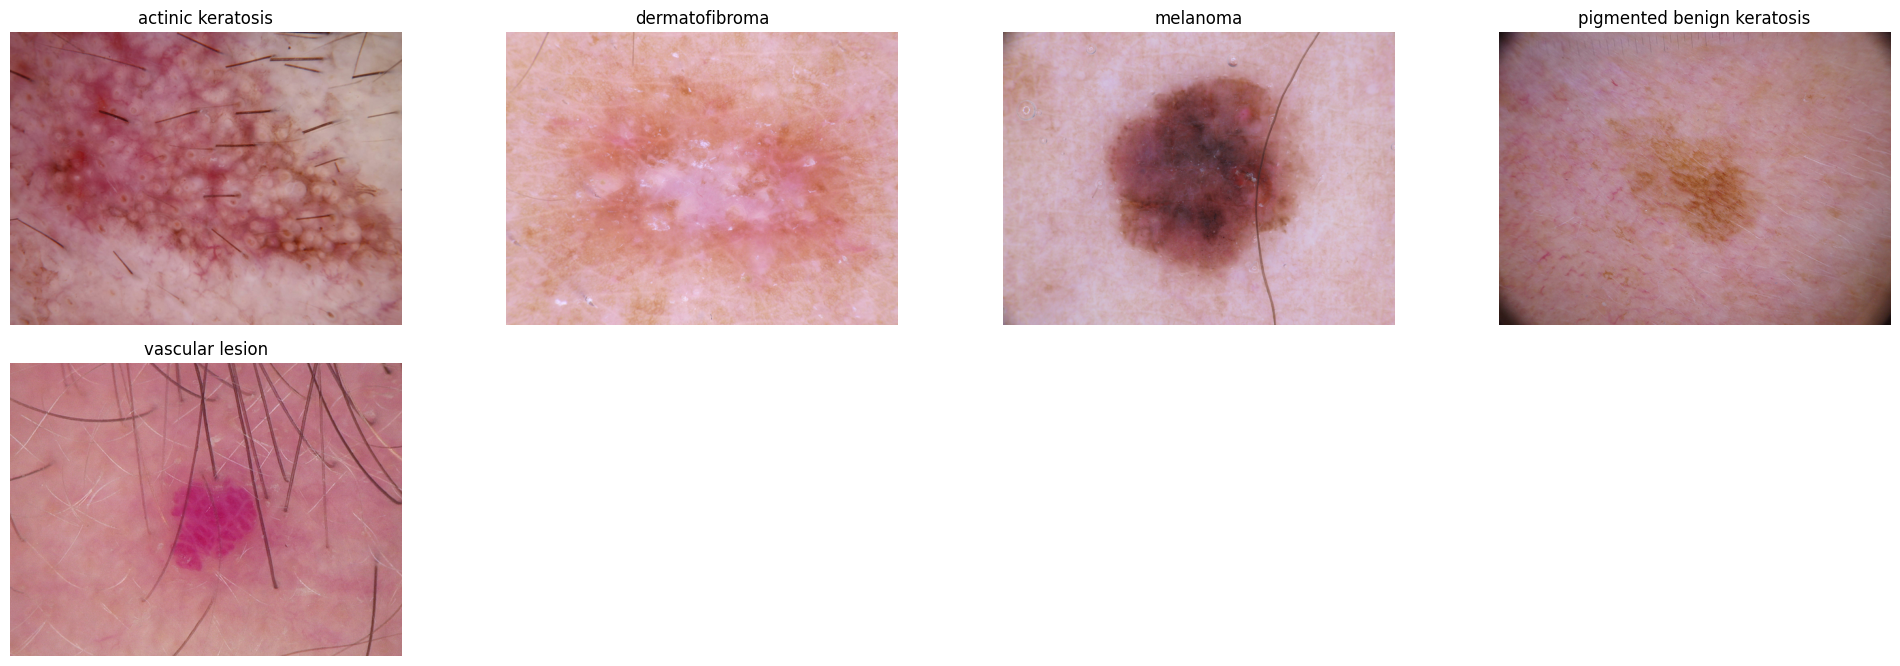

In [6]:
disease_folders = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Make plot for display first image in each class
plt.figure(figsize=(20, 20))


for i, disease_folder in enumerate(disease_folders):
   
    disease_folder_path = os.path.join(train_dir, disease_folder)
    
    
    image_files = os.listdir(disease_folder_path)
    
    if image_files:
        
        first_image_file = image_files[0]
        
       
        first_image_path = os.path.join(disease_folder_path, first_image_file)
        
        
        img = mpimg.imread(first_image_path)
        plt.subplot(6, 4, i + 1)  
        plt.imshow(img)
        plt.title(disease_folder)
        plt.axis('off')

# Show plot
plt.tight_layout()
plt.show()


**Make Data Generator**

In [7]:
# data augmentation generator for the data
datagen = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            validation_split=0.2)

In [8]:
train_ds = datagen.flow_from_directory(
    directory = train_dir,
    batch_size = 32,
    target_size = (224, 224),
    class_mode = 'categorical',
    subset='training'
)

Found 1001 images belonging to 5 classes.


In [9]:
validation_ds = datagen.flow_from_directory(
    directory = train_dir,
    batch_size = 32,
    target_size = (224, 224),
    class_mode = 'categorical',
    subset='validation'
)

Found 247 images belonging to 5 classes.


In [11]:
x_batch, y_batch = next(train_ds)
print(x_batch.shape, y_batch.shape)

(32, 224, 224, 3) (32, 5)


**Use Pre-trained Model (MobileNetV2)**

In [12]:
# Load the pre-trained MobileNetV2 model without the top classification layer
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),
                              pooling='avg')

# Freeze the pre-trained base model layers
MobileNetV2_base.trainable = False

**Fine-Tuning Model**

In [14]:
# Add new layers on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = MobileNetV2_base(inputs, training=False)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)

# Define the new model
model = Model(inputs, outputs)



model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,589 (11.64 MB)

 Trainable params: 791,045 (3.02 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

**Compile Model**

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Train Model**

In [18]:
batchsize = 32

history= model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 982ms/step - accuracy: 0.8973 - loss: 0.2899 - val_accuracy: 0.6235 - val_loss: 1.5264
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9165 - loss: 0.2428 - val_accuracy: 0.6721 - val_loss: 1.6284
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9028 - loss: 0.2757 - val_accuracy: 0.6640 - val_loss: 1.5275
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9026 - loss: 0.2685 - val_accuracy: 0.6883 - val_loss: 1.1710
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8853 - loss: 0.2920 - val_accuracy: 0.6640 - val_loss: 1.4246
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8834 - loss: 0.3168 - val_accuracy: 0.6721 - val_loss: 1.3907
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8717 - loss: 0.3636 - val_accuracy: 0.7247 - val_loss: 1.3572
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9099 - loss: 0.2598 - val_accuracy: 0.6883 - val_lo

**Evaluate Model**

In [26]:
# evaluate the model
loss, model_accuracy = model.evaluate(validation_ds)
loss_train, train_accuracy = model.evaluate(train_ds)

print("Train : accuracy = %f  ;  loss = %f" % (train_accuracy, loss_train))
print("Validation : accuracy = %f  ;  loss = %f" % (model_accuracy, loss))


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6677 - loss: 1.5812
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 952ms/step - accuracy: 0.9624 - loss: 0.1307
Train : accuracy = 0.955045  ;  loss = 0.134315
Validation : accuracy = 0.643725  ;  loss = 1.763821


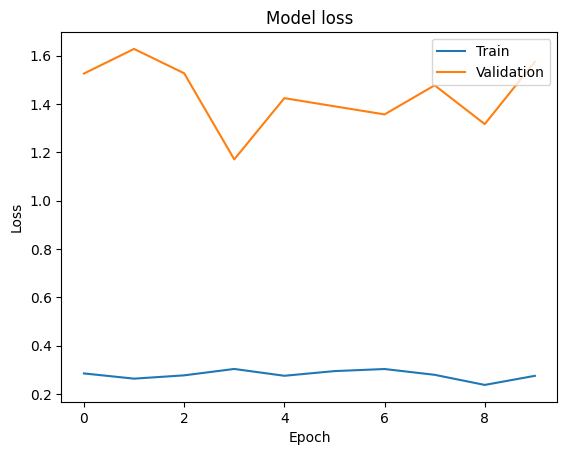

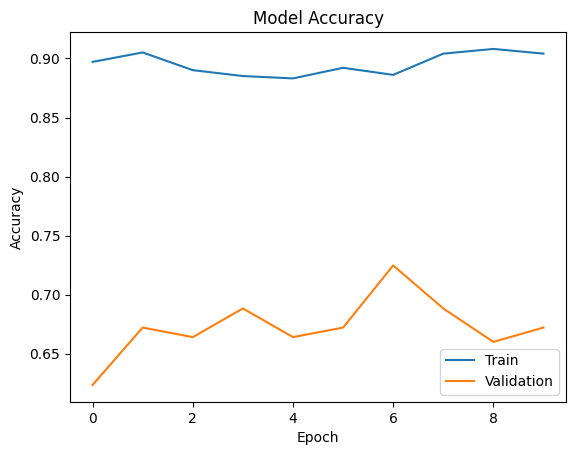

In [27]:
# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

**Save Model**

In [25]:
model.save('Skin-Disease.h5')

**Testing**

In [28]:
#labels
class_names = list(train_ds.class_indices.keys())
print(class_names)

['actinic keratosis', 'dermatofibroma', 'melanoma', 'pigmented benign keratosis', 'vascular lesion']


In [29]:
# Tampilkan prediksi dan percentage
def predict_class(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    percentage = np.max(predictions)*100
    f_percentage = f"{percentage:.2f}%"
    return predicted_class, f_percentage

# Tampilkan gambar input bersamaan dengan hasil prediksi
def display_prediction(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predict_class(img_path)}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


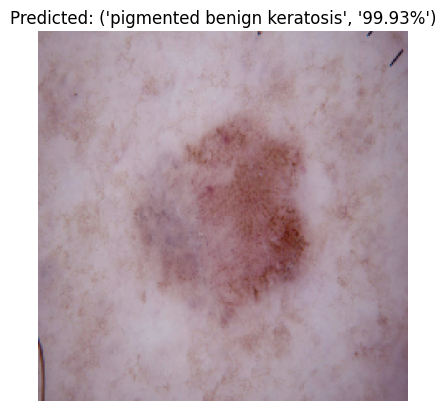

In [30]:
display_prediction('dataset/test/pigmented benign keratosis/ISIC_0024336.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


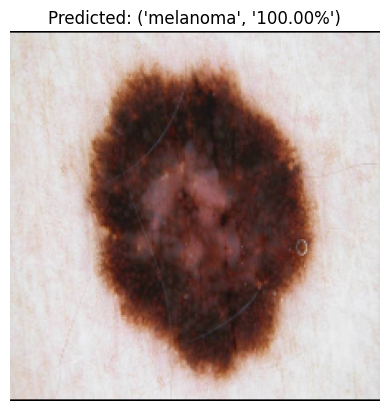

In [32]:
display_prediction('dataset/test/melanoma/ISIC_0000029.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


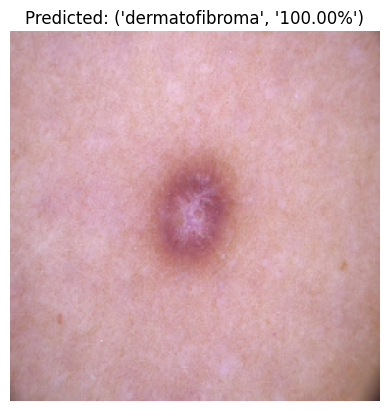

In [33]:
display_prediction('dataset/test/dermatofibroma/ISIC_0024396.jpg')